(2000, 1155, 3)


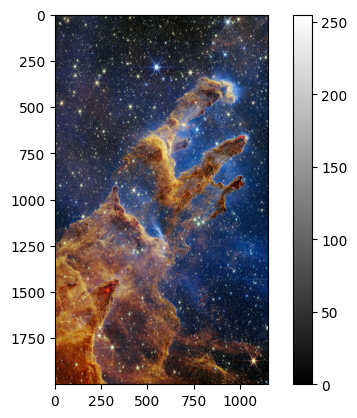

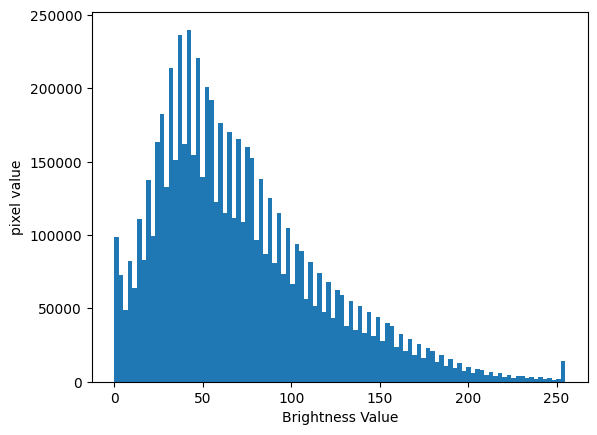

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Open the tiff file called "great pillars of creation" and read the image data
from PIL import Image
# im = Image.open('great pillars of creation.tif')
im = Image.open('gpoc.png')
image_data = np.array(im)
print(image_data.shape)


# Plot the image data
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.show()

# Show the distribution of brightness value in the image
# Label the axes
plt.xlabel('Brightness Value')
plt.ylabel('pixel value')
plt.hist(image_data.flat, bins=100, range=(0,255))
plt.show()

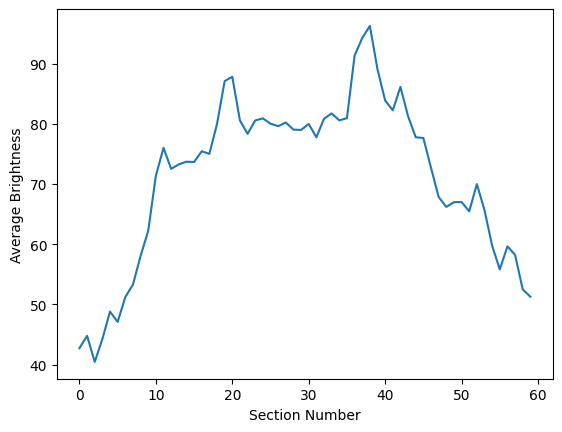

In [3]:
# Split the image top down into 20 sections, each with width 100 pixels. 
# Calculate the average brightness of each section and plot the results.
# Also print the each section of the
# This is a way to reduce the noise in the image
# We will use the numpy function reshape to split the image into sections
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html
# Label the x and y axis of the plot
image_data_reshaped = image_data.reshape(-1, 100, 1155)
image_data_reshaped_mean = np.mean(image_data_reshaped, axis=(1,2))
plt.plot(image_data_reshaped_mean)
plt.xlabel('Section Number')
plt.ylabel('Average Brightness')
plt.show()


In [4]:
# # Print the 60 splitted sections of the image (20 rows, 3 columns)
# for i in image_data_reshaped:
#     plt.imshow(i, cmap='gray')
#     plt.show()

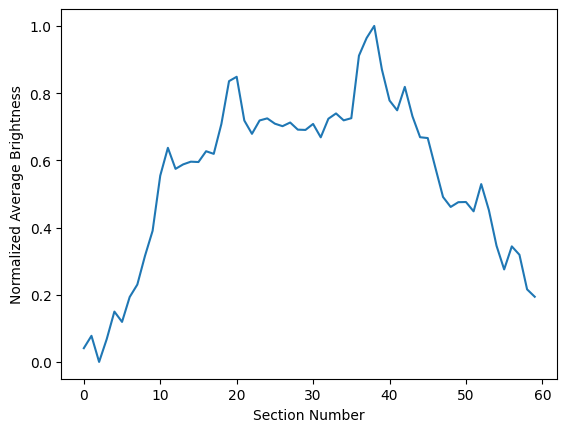

In [5]:
# Normalize the mean brightness of each section to the range 0 to 1

# Plot the normalized brightness of each section
# Label the x and y axis of the plot
def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

image_data_reshaped_mean_norm = map_value(image_data_reshaped_mean, np.min(image_data_reshaped_mean), np.max(image_data_reshaped_mean), 0, 1)
plt.plot(image_data_reshaped_mean_norm)
plt.xlabel('Section Number')
plt.ylabel('Normalized Average Brightness')
plt.show()



In [6]:
# Extract the brightest section of the image from image_data_reshaped
gray_img = im.convert('L')
b_max, b_min = 250, 150
print(b_max, b_min)
desired_pixels = [(x, y) for x in range(gray_img.width) for y in range(gray_img.height)
                  if b_min <= gray_img.getpixel((x, y)) <= b_max]

print(desired_pixels)


250 150
[(0, 80), (0, 115), (0, 116), (0, 221), (0, 222), (0, 223), (0, 353), (0, 354), (0, 444), (0, 505), (0, 582), (0, 583), (0, 585), (0, 658), (0, 695), (0, 696), (0, 749), (0, 883), (0, 1234), (0, 1280), (0, 1281), (0, 1282), (0, 1283), (0, 1284), (0, 1286), (0, 1287), (0, 1288), (0, 1289), (0, 1290), (0, 1291), (0, 1292), (0, 1293), (0, 1294), (0, 1295), (0, 1296), (0, 1298), (0, 1299), (0, 1300), (0, 1301), (0, 1302), (0, 1303), (0, 1304), (0, 1305), (0, 1306), (0, 1307), (0, 1308), (0, 1309), (0, 1310), (0, 1311), (0, 1312), (0, 1313), (0, 1314), (0, 1315), (0, 1316), (0, 1317), (0, 1318), (0, 1319), (0, 1320), (0, 1321), (0, 1322), (0, 1323), (0, 1324), (0, 1325), (0, 1326), (0, 1327), (0, 1328), (0, 1329), (0, 1330), (0, 1331), (0, 1332), (0, 1333), (0, 1334), (0, 1335), (0, 1336), (0, 1337), (0, 1338), (0, 1339), (0, 1340), (0, 1341), (0, 1344), (0, 1345), (0, 1346), (0, 1460), (0, 1461), (0, 1462), (0, 1526), (0, 1527), (0, 1534), (0, 1654), (0, 1665), (0, 1739), (0, 1740)

In [9]:
myrs_per_beat = 40  #number of pixel for each beat of music 

time = image_data  #time 
t_data = time/myrs_per_beat #rescale time from Myrs to beats


duration_beats = 40 #desired duration in beats (actually, onset of last note)

t_data = map_value(time, 0, max(time.all()), 0, duration_beats)

#or
#t_data = map_value(ages, min(ages), max(ages), duration_beats, 0)

myrs_per_beat = max(time)/duration_beats
print('Myrs per beat:', myrs_per_beat)

#calculate duration in seconds
bpm = 60  #if bpm = 60, 1 beat = 1 sec 
duration_sec = duration_beats*60/bpm #duration in seconds (actually, onset of last note)
print('Duration:', duration_sec, 'seconds')

TypeError: 'numpy.bool_' object is not iterable

In [ ]:
from audiolazy import str2midi

#custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

note_midis = [str2midi(n) for n in note_names]
n_notes = len(note_midis)
print('Resolution:',n_notes, 'notes')